In [ ]:
import cv2 #open-source library to process images
import glob #os manages and creates specific paths that are friendly to whatever machine they are used on, glob helps to filter through large datasets and pull out files of interest
import os
import numpy as np

SIZE = 224  #Resize images

#Capture training data and labels into respective lists
dataset = []
labels = []
count = 0

for directory_path in glob.glob("/content/drive/MyDrive/Weather_pics/Multi-class Weather Dataset/*"):
    label =  os.path.basename(directory_path)
    print(label)
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):

      img = cv2.imread(img_path, cv2.IMREAD_COLOR) #imread() decodes the image into a matrix with the color channels stored in the order of Blue, Green, Red and A (Transparency) respectively.

      if img is not None:
        img = cv2.resize(img, (SIZE, SIZE),interpolation=cv2.INTER_AREA) #Interpolation is the way the extra pixels in the new image is calculated. (downscaling)
        dataset.append(img)
        labels.append(label)

      else:
        continue


# #Convert lists to arrays
dataset = np.array(dataset)
labels = np.array(labels)

print('\nThe shape of images dataset : ',dataset.shape)
print("The shape of images labels : ",labels.shape)

Cloudy
Sunrise
Rain
Sunny
Snowy

The shape of images dataset :  (1284, 224, 224, 3)
The shape of images labels :  (1284,)


In [ ]:
#IMAGE AUGMENTATION AND RESIZING
from keras.preprocessing.image import ImageDataGenerator

import warnings
warnings.filterwarnings("ignore") #to ignore extra whitespaces

SIZE = 224          # Resize images
SCALE = 1 / 255.0   # Scale factor for rescaling
#Image augmentation parameters are used to increase sample count are zoom, shear, rotation, preprocessing_function

num_augmentations  = 3   # Number of augmented images per original image
#The ImageDataGenerator class allows your model to receive new variations of the images at each epoch.
# Define augmentation parameters
datagen = ImageDataGenerator(


          rotation_range=45,       # Random rotation between 0 and 45 degrees
          width_shift_range=0.2,   # Random horizontal shift of up to 20% of the image width
          height_shift_range=0.2,  # Random vertical shift of up to 20% of the image height
          shear_range=0.2,         # Random shearing transformation
          zoom_range=0.2,          # Random zoom between 80% and 120% of original size
          horizontal_flip=True,    # Randomly flip the images horizontally
          fill_mode='reflect')     # Strategy for filling in newly created pixels after rotation or shifting

# Capture training data and labels into respective lists
dataset = []  # List to store augmented images
labels = []   # List to store corresponding labels

for directory_path in glob.glob("/content/drive/MyDrive/Weather_pics/Multi-class Weather Dataset/*"):
    label = os.path.basename(directory_path)    # Extracting the label from the directory path
    print(label)
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)

        if img is not None:
            img = cv2.resize(img, (SIZE, SIZE), interpolation=cv2.INTER_AREA)  # Resize the image
            img = img * SCALE    # Rescale the image

            augmented_images = datagen.flow(np.expand_dims(img, axis=0), batch_size=1)

            for _ in range(num_augmentations):
                augmented_img = augmented_images.next()[0]  # Retrieve the augmented image
                dataset.append(augmented_img)               # Add the augmented image to the dataset list
                labels.append(label)                        # Add the corresponding label to the labels list

        else:
            continue

# Convert lists to arrays
dataset = np.array(dataset)  # Convert the dataset list to a NumPy array
labels = np.array(labels)    # Convert the labels list to a NumPy array

print('\nThe shape of images dataset after augmentation:', dataset.shape)   # Print the shape of the dataset
print('The shape of images labels after augmentation:', labels.shape)       # Print the shape of the labels

Cloudy
Sunrise
Rain
Sunny
Snowy

The shape of images dataset after augmentation: (3852, 224, 224, 3)
The shape of images labels after augmentation: (3852,)


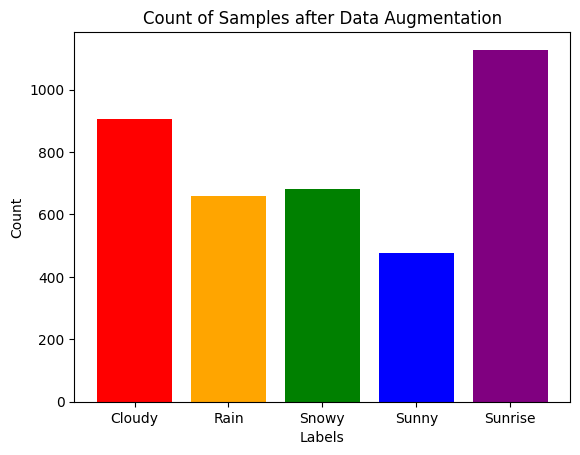

In [ ]:
#EDA
import numpy as np
import matplotlib.pyplot as plt

# Count the occurrences of each label
label_counts = np.unique(labels, return_counts=True)

# Extract the unique labels and their corresponding counts
unique_labels = label_counts[0]
label_counts = label_counts[1]

# Calculate the percentage of each label
label_percentages = (label_counts / len(labels)) * 100

colors = ['red', 'orange', 'green', 'blue','purple']

plt.bar(unique_labels, label_counts, color=colors)

# # Display the percentage on top of each bar
# for i, count in enumerate(label_counts):
#     percentage = label_percentages[i]
#     plt.text(unique_labels[i], count, f'{percentage:.2f}%', ha='center', va='bottom')

plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Count of Samples after Data Augmentation')

plt.show()

In [ ]:
#SPLITTING DATA
from sklearn.utils import shuffle #shuffle is used to do random permutations of matrix

# Assuming having features (X) and labels (y) arrays
#dataset has list of augmented images
X, y = shuffle(dataset, labels, random_state=42)

split_ratio = 0.9  # Specify the desired split ratio
split_index = int(len(X) * split_ratio)

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]


# encode labels from text to integers
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(y_train)
le.fit(y_test)

y_train = le.transform(y_train)
y_test = le.transform(y_test)


# One Hot Encoding (converting to binary data)
from keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
#X_train has (no of images,width,breadth,height)
print(f'{X_train.shape[0]} samples for training.')
print(f'{X_test.shape[0]} samples for testing.')
print(X_train.shape)

3466 samples for training.
386 samples for testing.
(3466, 224, 224, 3)


In [ ]:
#MODEL IMPLEMENTATION
from keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dropout, Dense
from keras import Model, backend as k
from keras import optimizers
k.clear_session()
#Input() is used to instantiate a Keras tensor (size,size,output number)
#In a 2 dimensional CNN, the kernel moves in 2 directions.CNN is 3 dimensional.
#Flattening is used to converts the resultant 2-Dimensional arrays from pooled feature maps into a linear vector.
#DropOut randomly ignores irrelevant neurons during tarining
#Every neuron in the dense layer takes the input from all the other neurons of the previous layer.(product kernel)
input_layer = Input(shape = (SIZE, SIZE, 3))
'''Keras is a model-level library,it does not handle itself low-level operations such as tensor products,
convolutions and so on.Instead, it relies on a specialized, well-optimized tensor manipulation library,
serving as the "backend engine" of Keras. Rather than picking one single tensor library and
making the implementation of Keras tied to that library, Keras handles the problem in a modular way,
and several backend engines can be plugged into Keras (Theano,Tensorflow).'''
#Optimizers change the attributes of model such as weights and learning rate in order to reduce the losses.

#CNN Convolutional Layers

#One-block model has two single convolutional layer with 32, 16 filters followed
#by a max pooling layer.

conv1 = Conv2D(32, (3, 3), activation = 'relu', padding = 'same' )(input_layer)
conv2 = Conv2D(16, (3, 3), activation = 'relu', padding = 'same' )(conv1)
pooling_layer = MaxPool2D(pool_size = (2, 2))(conv2)
'''Valid padding is a technique used in(CNNs) to process the input data without adding any additional rows or columns
of pixels around the edges of the data. Same padding adds additional rows and columns of pixels around the edges
of the input data so that the size of the output feature map is the same as the size of the input data.'''
#FC Fully Connected layers for classification with one flatten, one dense and one dropout layer
flatten_layer = Flatten()(pooling_layer)
dense = Dense(200, activation='relu')(flatten_layer)
dropout = Dropout(0.5)(dense)
# The dense layer receivesflattened output from the previous layers and applies set of weights to produce the final output.
# ouput layer with “softmax” activation function.
output_layer = Dense(5, activation='softmax')(dropout)
#The softmax, or “soft max,” mathematical function can be thought to be a probabilistic
model1 = Model(inputs =input_layer, outputs = output_layer)
# Compiling the model
model1.compile(optimizer = 'adam', loss= 'categorical_crossentropy', metrics=['accuracy'])
#Adam  (Adaptive Moment Estimation algorithm)is a further extension of stochastic gradient descent to update network weights during training.
#Also called Softmax Loss. It's a Softmax activation and a Cross-Entropy loss.(Others are Cross-Entropy,Binary,Focal)
model1.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 16)      4624      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 200704)            0         
                                                                 
 dense (Dense)               (None, 200)               40141000  
                                                             

In [ ]:
model1.fit(X_train,
          y_train,
          validation_split=0.1,
          batch_size=64,
          epochs=32,
          )
#the validation_split parameter refers to the portion of the training data set-aside that is used for validation during the training process.

Epoch 1/32
49/49 [==============================] - 431s 9s/step - loss: 3.6646 - accuracy: 0.4376 - val_loss: 1.0833 - val_accuracy: 0.5476
Epoch 2/32
49/49 [==============================] - 425s 9s/step - loss: 0.8456 - accuracy: 0.6922 - val_loss: 0.6855 - val_accuracy: 0.7464
Epoch 3/32
49/49 [==============================] - 417s 8s/step - loss: 0.6247 - accuracy: 0.7746 - val_loss: 0.6279 - val_accuracy: 0.7925
Epoch 4/32
49/49 [==============================] - 410s 8s/step - loss: 0.5826 - accuracy: 0.7913 - val_loss: 0.6338 - val_accuracy: 0.7435
Epoch 5/32
49/49 [==============================] - 411s 8s/step - loss: 0.4993 - accuracy: 0.8243 - val_loss: 0.6563 - val_accuracy: 0.7896
Epoch 6/32
49/49 [==============================] - 410s 8s/step - loss: 0.3453 - accuracy: 0.8836 - val_loss: 0.5931 - val_accuracy: 0.7983
Epoch 7/32
49/49 [==============================] - 421s 9s/step - loss: 0.2436 - accuracy: 0.9195 - val_loss: 0.6074 - val_accuracy: 0.7781
Epoch 8/32
49

In [ ]:
print("Test_Accuracy: {:.2f}%".format(model1.evaluate(X_test, y_test)[1]*100))

13/13 [==============================] - 13s 1s/step - loss: 1.0169 - accuracy: 0.8057
Test_Accuracy: 80.57%


13/13 [==============================] - 12s 945ms/step


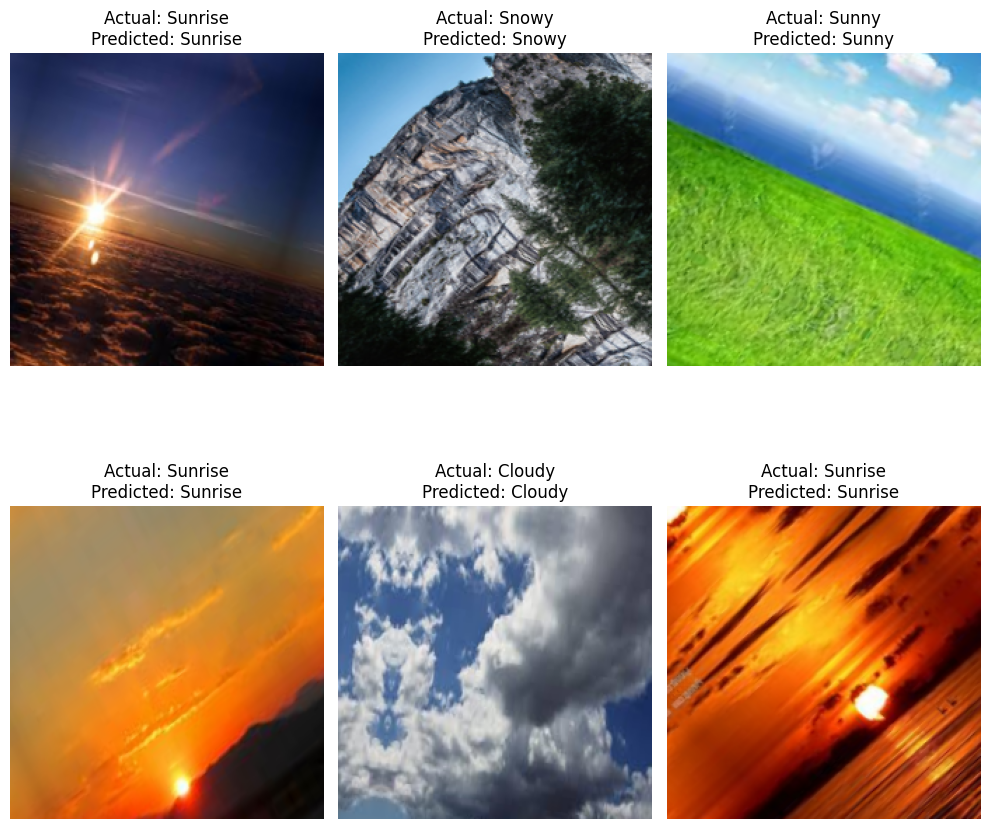

In [ ]:
# predict the labels agianst x_test
y_predict = model1.predict(X_test)

# Reverse label encoding
reverse_encoded_labels = le.inverse_transform(np.argmax(y_test, axis=1))

# Reverse one-hot encoding for predicted labels
reverse_predicted_labels = le.inverse_transform(np.argmax(y_predict, axis=1))

# Plotting images with labels
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 10))

# Convert BGR image to RGB

for i, ax in enumerate(axes.flat):
    ax.imshow(cv2.cvtColor(X_test[i], cv2.COLOR_BGR2RGB))
    ax.set_title(f'Actual: {reverse_encoded_labels[i]}\nPredicted: {reverse_predicted_labels[i]}')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
#MODEL-2
from keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dropout, Dense
from keras import Model, backend as k
from keras import optimizers
k.clear_session() #clear model numbers

input_layer = Input(shape = (SIZE, SIZE, 3))

#CNN Convolutional Layers

#Block 1: Two 32 filter layers, followed by a max pooling layer.
conv11 = Conv2D(32, (3, 3), activation = 'relu', padding = 'same' )(input_layer)
conv12 = Conv2D(32, (3, 3), activation = 'relu', padding = 'same' )(conv11)
pooling_layer1 = MaxPool2D(pool_size = (2, 2))(conv12)

#Block 2: Two 64 filter layers, followed by a max pooling layer.
conv21 = Conv2D(64, (3, 3), activation = 'relu', padding = 'same' )(pooling_layer1)
conv22 = Conv2D(64, (3, 3), activation = 'relu', padding = 'same' )(conv21)
pooling_layer2 = MaxPool2D(pool_size = (2, 2))(conv22)


#FC Fully connected: two dense and two dropout layers
flatten_layer = Flatten()(pooling_layer2)
dense1 = Dense(200, activation='relu')(flatten_layer)
dropout1 = Dropout(0.5)(dense1)

dense2 = Dense(100, activation='relu')(dropout1)

#finally the output layer with “softmax” activation function.
output_layer = Dense(5, activation='softmax')(dense2)

model2 = Model(inputs =input_layer, outputs = output_layer)

#Compiling the model
model2.compile(optimizer = 'adam', loss= 'categorical_crossentropy', metrics=['accuracy'])

model2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 64)      36928     
                                                             

In [ ]:
model2.fit(X_train,
          y_train,
          validation_split=0.1,
          batch_size=64,
          epochs=10
          )

Epoch 1/10
49/49 [==============================] - 967s 20s/step - loss: 1.2435 - accuracy: 0.4925 - val_loss: 0.9787 - val_accuracy: 0.5504
Epoch 2/10
49/49 [==============================] - 974s 20s/step - loss: 0.8800 - accuracy: 0.6438 - val_loss: 0.7470 - val_accuracy: 0.7147
Epoch 3/10
49/49 [==============================] - 1045s 21s/step - loss: 0.7425 - accuracy: 0.7172 - val_loss: 0.5799 - val_accuracy: 0.7896
Epoch 4/10
49/49 [==============================] - 1002s 20s/step - loss: 0.6021 - accuracy: 0.7650 - val_loss: 0.4901 - val_accuracy: 0.8386
Epoch 5/10
49/49 [==============================] - 978s 20s/step - loss: 0.5166 - accuracy: 0.7990 - val_loss: 0.4731 - val_accuracy: 0.8012
Epoch 6/10
49/49 [==============================] - 989s 20s/step - loss: 0.4345 - accuracy: 0.8336 - val_loss: 0.4645 - val_accuracy: 0.8501
Epoch 7/10
49/49 [==============================] - 998s 20s/step - loss: 0.3872 - accuracy: 0.8602 - val_loss: 0.4544 - val_accuracy: 0.8357
Epoc

In [ ]:
print("Test_Accuracy: {:.2f}%".format(model2.evaluate(X_test, y_test)[1]*100))

13/13 [==============================] - 29s 2s/step - loss: 0.6854 - accuracy: 0.8342
Test_Accuracy: 83.42%
